In [1]:
import os
import shutil
import wandb
import torch
%load_ext autoreload

# Step 1: Clear Environment Variables
os.environ.pop('WANDB_API_KEY', None)

# Step 2: Clear Wandb Config Directory
wandb_config_dir = os.path.expanduser("~/.config/wandb")
if os.path.exists(wandb_config_dir):
    shutil.rmtree(wandb_config_dir)

import os
print("CUDA_VISIBLE_DEVICES:", os.environ.get('CUDA_VISIBLE_DEVICES'))

# Try to force PyTorch to see the GPU
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

!nvidia-smi

print("PyTorch version:", torch.__version__)
print("Is CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda if torch.cuda.is_available() else "N/A")

# Print information about available GPUs
if torch.cuda.is_available():
    print("Number of GPUs:", torch.cuda.device_count())
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
else:
    print("No GPU available")

# Check if CUDA is initialized
print("Is CUDA initialized:", torch.cuda.is_initialized())

# If CUDA is available but not initialized, try to initialize it
if torch.cuda.is_available() and not torch.cuda.is_initialized():
    try:
        torch.cuda.init()
        print("CUDA initialized successfully")
    except Exception as e:
        print(f"Failed to initialize CUDA: {e}")

# Set the default tensor type to cuda if available
if torch.cuda.is_available():
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
    print("Default tensor type set to CUDA")
else:
    print("Using CPU tensors")

CUDA_VISIBLE_DEVICES: None
Mon Jul 15 18:34:28 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.06             Driver Version: 535.183.06   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A10G                    Off | 00000000:00:1E.0 Off |                    0 |
|  0%   31C    P8              16W / 300W |      3MiB / 23028MiB |      0%      Default |
|                                         |                      |                  N/A |
+----------------------------------------

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/__init__.py:696: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:451.)
  _C._set_default_tensor_type(t)


In [2]:
import sys
sys.path.append('/teamspace/studios/this_studio/wildfire-ignition-generator/src')
import os
os.chdir('/teamspace/studios/this_studio/wildfire-ignition-generator')


In [16]:
!pwd


/teamspace/studios/this_studio/wildfire-ignition-generator


In [4]:
from src.data.geo_data_handler import GeoDataHandler
from src.data.preprocessor import WildfireDataProcessor
from src.data.inference_engine import WildfireInferenceEngine

from src.utils.tile_manager import TileManager
from src.models.cnf_utils import CNFUtils
from src.models.normalizing_flow import ConditionalNormalizingFlow


def reload_mods():
    """
    Function to toggle the automatic reloading of modules in an IPython environment.
    It enables the autoreload feature which reloads modules automatically before executing code.
    """
    # Enable autoreload mode 2, which reloads all modules (except those excluded by %aimport)
    %autoreload 2
    print("Auto-reloading of all modules is enabled.")

# Usage
reload_mods()


def process_ignitions_csv(self, csv_path, output_path, date, percentile=95):
    # Load the ignitions CSV
    ignitions_gdf = self.load_ignitions_csv(csv_path)
    
    # Prepare the data for prediction
    X, merged_df = self.prepare_ignitions_for_prediction(ignitions_gdf, date)
    
    # Predict fire sizes
    final_df = self.predict_fire_sizes(X, merged_df)
    
    # Calculate the stop size based on the percentile prediction
    final_df['stop_at_size'] = final_df[f'{percentile}th_percentile']
    
    # Add the stop size to the original dataframe
    ignitions_gdf['stop_at_size'] = final_df['stop_at_size']
    
    # Save the updated dataframe
    ignitions_gdf.to_csv(output_path, index=False)
    
    return ignitions_gdf

Auto-reloading of all modules is enabled.


# Operational

In [7]:
!pwd

/teamspace/studios/this_studio/wildfire-ignition-generator


In [8]:
import pandas as pd 
pd.read_csv('data/sheets/006_036.csv')

iwx_band              date         lon        lat  erc  bi  wui proximity
0           23  2020-01-01 22:00 -120.015003  37.489699   15  26            0.0
1           61  2020-01-03 12:00 -120.503833  37.650165   20  29            0.0
2           96  2020-01-04 23:00 -120.347474  37.662281   19  28            0.0
3          474  2020-01-20 17:00 -120.294901  37.739406   39  35            0.0
4          713  2020-01-30 16:00 -120.381406  37.418175   36  35            0.0
...        ...               ...         ...        ...  ...  ..            ...
3406      8571  2020-12-23 02:00 -120.048452  37.631419   48  49            0.0
3407      8616  2020-12-24 23:00 -120.094975  37.403291   52  44            0.0
3408      8635  2020-12-25 18:00 -119.996293  37.444816   39  17            0.0
3409      8662  2020-12-26 21:00 -120.504676  37.555037   28  14            0.0
3410      8667  2020-12-27 02:00 -120.468701  37.676483   21  15          450.0

[3411 rows x 7 columns]

Auto-reloading of all modules is enabled.
Loading pyrome files ...
Unique Pyrome: [  1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.
  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  55.  56.  57.
  58.  59.  60.  61.  62.  65.  67.  77.  78.  89. 127. 128.]
Loading pyrome shapefile...
Pyrome shapefile loaded and indexed.


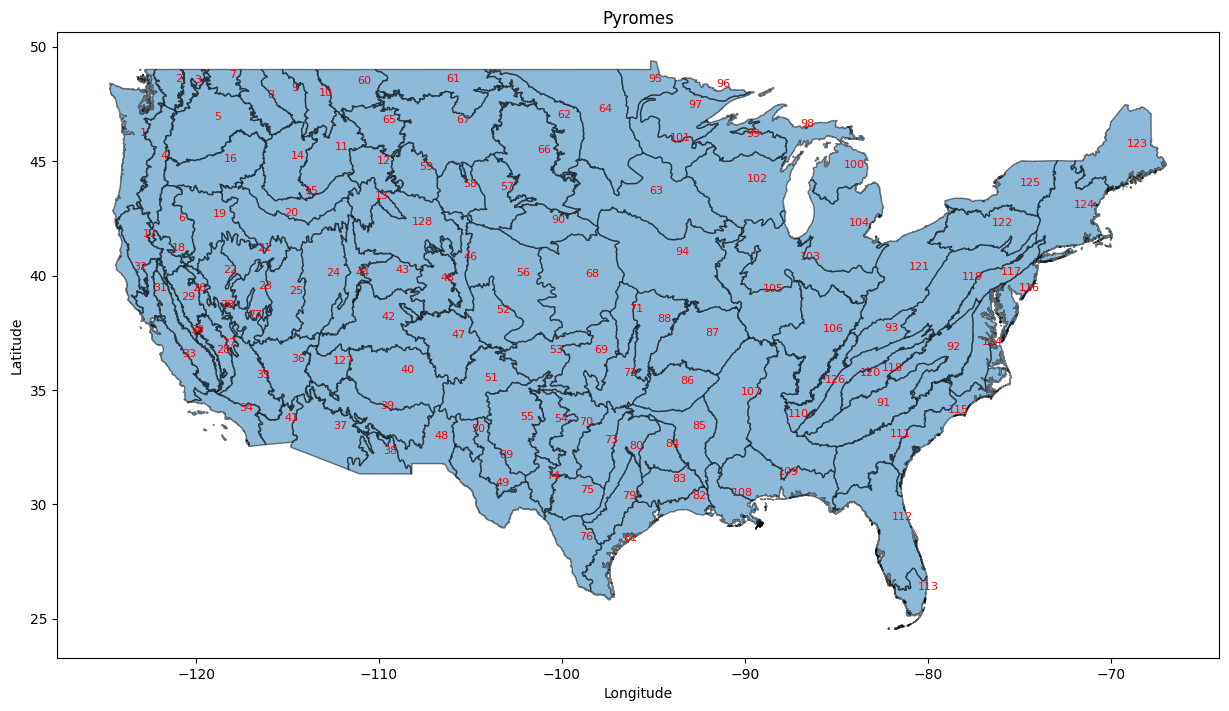

Loading preprocessor files from: data/processed/processor
Preprocessor files loaded successfully!

=== Preprocessor Statistics ===

1. Scaler Statistics:
   Features scaled:
   - Latitude:
     Mean: 39.5174
     Scale: 4.8873
   - Longitude:
     Mean: -112.8101
     Scale: 6.6724
   - ERC_percentile:
     Mean: 50.0454
     Scale: 28.8556
   - WUI proximity_percentile:
     Mean: 50.0454
     Scale: 25.4220
   - BI_percentile:
     Mean: 50.0454
     Scale: 28.8546
   - ignition_sin:
     Mean: -0.1663
     Scale: 0.6213
   - ignition_cos:
     Mean: -0.5645
     Scale: 0.5173

2. Encoder Information:
   Pyrome Categories:
   - 1
   - 2
   - 3
   - 4
   - 5
   - 6
   - 7
   - 8
   - 9
   - 10
   - 11
   - 12
   - 13
   - 14
   - 15
   - 16
   - 17
   - 18
   - 19
   - 20
   - 21
   - 22
   - 23
   - 24
   - 25
   - 26
   - 27
   - 28
   - 29
   - 30
   - 31
   - 32
   - 33
   - 34
   - 35
   - 36
   - 37
   - 38
   - 39
   - 40
   - 41
   - 42
   - 43
   - 44
   - 45
   - 46
   - 47


In [52]:
reload_mods()

from src.data.geo_data_handler import GeoDataHandler
from src.data.preprocessor import WildfireDataProcessor
from src.data.inference_engine import WildfireInferenceEngine

from src.utils.tile_manager import TileManager
from src.models.cnf_utils import CNFUtils
from src.models.normalizing_flow import ConditionalNormalizingFlow


processor = WildfireDataProcessor()
processor.load() 
processor.print_preprocessor_stats()

In [32]:
file_path = 'data/sheets/010_024.csv'
df = pd.read_csv(file_path)
df = processor.add_pyrome_column(df)
df = processor.rename_columns(df)


In [44]:
df_proc = processor.transform(df)



Initial DataFrame:
Total NaN count: 0

After selecting relevant columns:
Total NaN count: 0

After filtering for Western US:
Total NaN count: 0

After handling missing values:
Total NaN count: 0

After percentile conversion:
Total NaN count: 0
Number of rows before one-hot encoding: 3397
   Pyrome_34  Pyrome_41
0          1          0
1          1          0
2          1          0
3          1          0
4          1          0
Pyrome columns after adding missing ones:
['Pyrome_1', 'Pyrome_2', 'Pyrome_3', 'Pyrome_4', 'Pyrome_5', 'Pyrome_6', 'Pyrome_7', 'Pyrome_8', 'Pyrome_9', 'Pyrome_10', 'Pyrome_11', 'Pyrome_12', 'Pyrome_13', 'Pyrome_14', 'Pyrome_15', 'Pyrome_16', 'Pyrome_17', 'Pyrome_18', 'Pyrome_19', 'Pyrome_20', 'Pyrome_21', 'Pyrome_22', 'Pyrome_23', 'Pyrome_24', 'Pyrome_25', 'Pyrome_26', 'Pyrome_27', 'Pyrome_28', 'Pyrome_29', 'Pyrome_30', 'Pyrome_31', 'Pyrome_32', 'Pyrome_33', 'Pyrome_34', 'Pyrome_35', 'Pyrome_36', 'Pyrome_37', 'Pyrome_38', 'Pyrome_39', 'Pyrome_40', 'Pyrome_41',

In [ ]:
df_proc

In [53]:

X, y = processor.prepare_for_training(df_proc)

Shape of features (X) after dropping 'Acres' and 'Ignition date': (3397, 75)
Shape of target (y) after selection: (3397,)
Target variable log-transformed.
First few entries of X:
[[-1.38466668 -0.6050211  -1.73164561 -0.46855752 -1.63037375  0.29523368
   3.02393931  0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          1.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.    

In [51]:
df_proc

Latitude  Longitude  ...       Ignition date  original_index
0    -1.384667  -0.605021  ... 2020-01-01 09:00:00               0
1    -1.391936  -0.605231  ... 2020-01-01 19:00:00               1
2    -1.355152  -0.605553  ... 2020-01-03 20:00:00               2
3    -1.335629  -0.604127  ... 2020-01-04 00:00:00               3
4    -1.376952  -0.597725  ... 2020-01-04 00:00:00               4
...        ...        ...  ...                 ...             ...
3392 -1.371212  -0.591968  ... 2020-12-27 13:00:00            3392
3393 -1.382194  -0.588594  ... 2020-12-27 13:00:00            3393
3394 -1.376335  -0.610609  ... 2020-12-27 18:00:00            3394
3395 -1.383407  -0.603834  ... 2020-12-27 21:00:00            3395
3396 -1.388696  -0.579077  ... 2020-12-27 23:00:00            3396

[3397 rows x 78 columns]

Failed to add basemap: 'NoneType' object has no attribute 'shape'
Continuing without basemap...


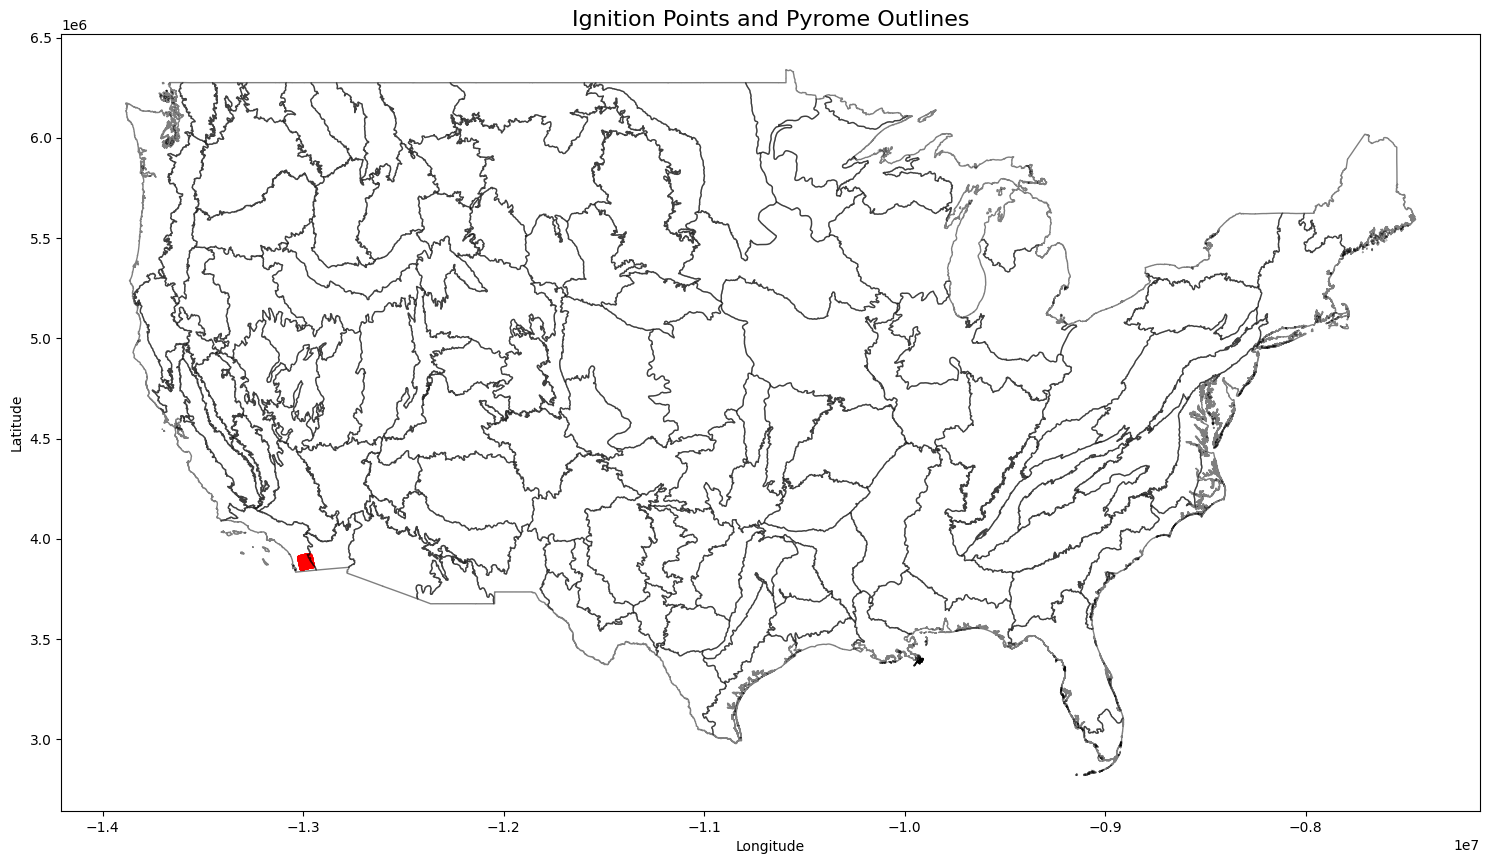

In [26]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from shapely.geometry import Point

def plot_ignitions_with_pyromes(df, pyrome_shapefile_path, output_path=None):
    """
    Plot ignition points on a map with pyrome outlines in the background.

    Args:
    df (pandas.DataFrame): DataFrame containing 'Latitude' and 'Longitude' columns
    pyrome_shapefile_path (str): Path to the pyrome shapefile
    output_path (str, optional): Path to save the output image. If None, the plot is displayed instead.
    """
    # Load pyrome shapefile
    pyromes = gpd.read_file(pyrome_shapefile_path)
    pyromes = pyromes.to_crs(epsg=3857)  # Web Mercator projection

    # Create GeoDataFrame from the input DataFrame
    geometry = [Point(xy) for xy in zip(df['Longitude'], df['Latitude'])]
    gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")
    gdf = gdf.to_crs(epsg=3857)  # Web Mercator projection

    # Create the plot
    fig, ax = plt.subplots(figsize=(15, 10))

    # Plot pyrome outlines
    pyromes.boundary.plot(ax=ax, linewidth=1, color='black', alpha=0.5)

    # Plot ignition points
    gdf.plot(ax=ax, color='red', markersize=5, alpha=0.6)

    # Try to add basemap, if it fails, continue without it
    try:
        ctx.add_basemap(ax, source=ctx.providers.Stamen.TerrainBackground)
    except Exception as e:
        print(f"Failed to add basemap: {e}")
        print("Continuing without basemap...")

    # Set plot title and labels
    plt.title("Ignition Points and Pyrome Outlines", fontsize=16)
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")

    # Keep axis values as we might not have a basemap
    ax.set_axis_on()

    # Adjust layout
    plt.tight_layout()

    # Save or display the plot
    if output_path:
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        print(f"Plot saved to {output_path}")
    else:
        plt.show()


import pandas as pd

# Load your DataFrame

# Path to your pyrome shapefile
pyrome_shapefile_path = 'data/pyrome_shp/Pyromes_CONUS_20200206.shp'

# Plot and save
plot_ignitions_with_pyromes(df, pyrome_shapefile_path)

In [19]:
df['Pyrome'].unique()

array([34, 41])

Auto-reloading of all modules is enabled.
Configuration saved to data/outputs/7b9dd5/config.json
Files will be saved to: data/outputs/7b9dd5
Loading pyrome shapefile...
Pyrome shapefile loaded and indexed.


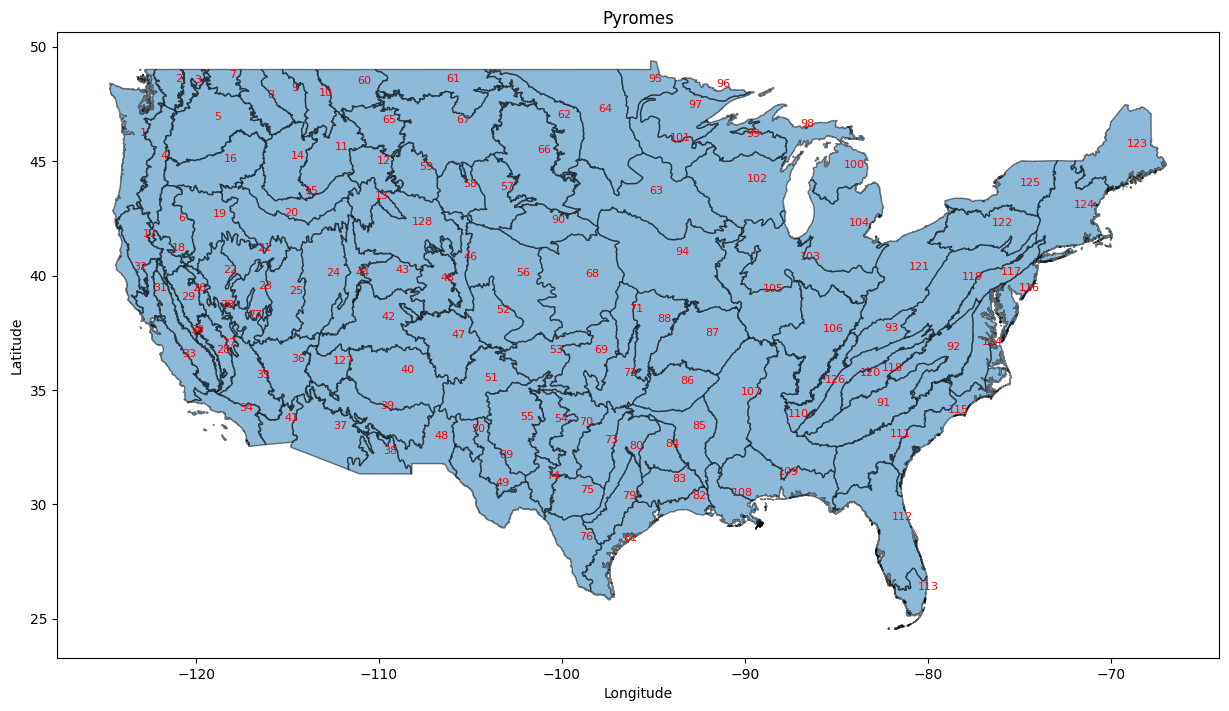

Loading pyrome files ...
Unique Pyrome: [  1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.
  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  55.  56.  57.
  58.  59.  60.  61.  62.  65.  67.  77.  78.  89. 127. 128.]
Loading pyrome shapefile...
Pyrome shapefile loaded and indexed.


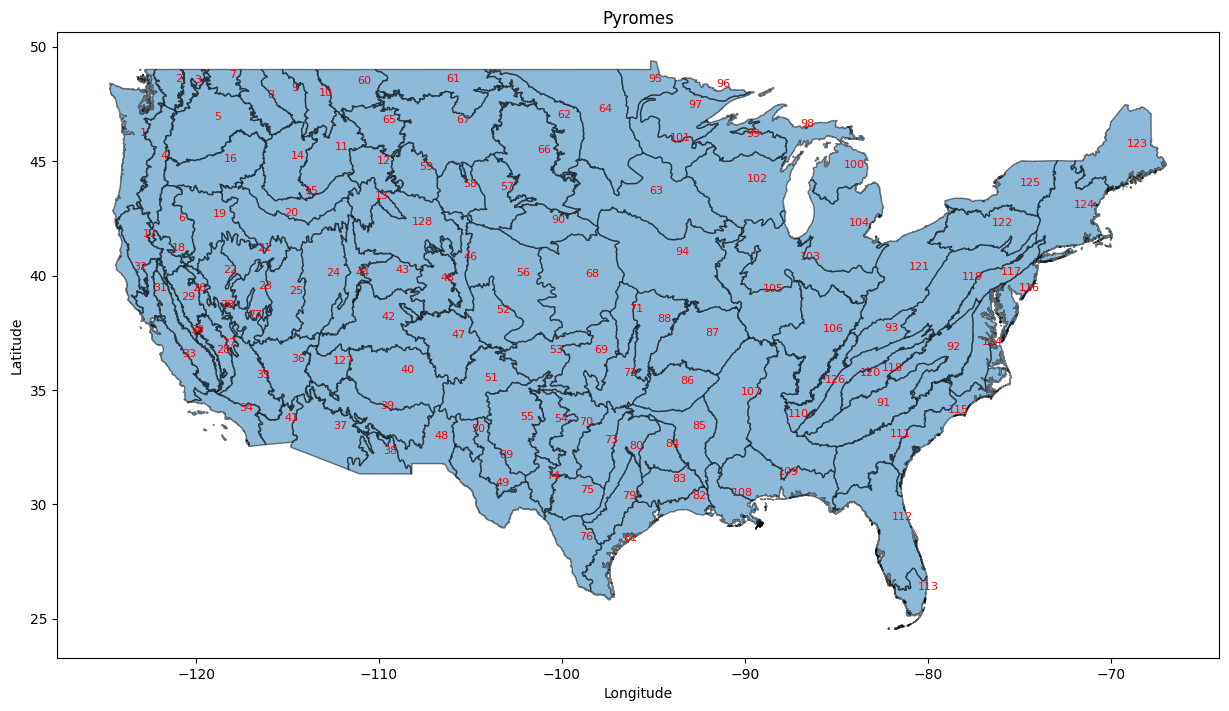

Loading preprocessor files from: data/processed/processor
Preprocessor files loaded successfully!
Available model files: ['model_4501.pth']
Loading the latest model: model_4501.pth
ConditionalNormalizingFlow initialized with the following parameters:
Context size: 75
Latent size: 1
Number of flow layers: 4
Hidden units per layer: 128
Number of hidden layers: 3
Device: cuda
model set to eval. Ready to go!
--------------------------------------------------
loaded Inference Engine
--------------------------------------------------


In [54]:

reload_mods()

from src.data.geo_data_handler import GeoDataHandler
from src.data.preprocessor import WildfireDataProcessor
from src.data.inference_engine import WildfireInferenceEngine

from src.utils.tile_manager import TileManager
from src.models.cnf_utils import CNFUtils
from src.models.normalizing_flow import ConditionalNormalizingFlow




# Initialize the WildfireInferenceEngine
config = {
    'data_dir': "data/wildfire_indicators/raw_netcdfs",
    'wui_data_path': 'path_to_wui_proximity.tif',
    'model_dir': 'data/artifacts/run-n6xf1a04-history:v0/local',
    'context_size': 75,
    'latent_size': 1,
    'num_flow_layers': 4,
    'hidden_units': 128,
    'hidden_layers': 3,
    'pyrome_shapefile_path': 'data/pyrome_shp/Pyromes_CONUS_20200206.shp'
}

engine = WildfireInferenceEngine(config)

# Load the necessary data
#engine.load_data(2023)  # Assuming the ignitions are for 2023



In [55]:
X.shape

torch.Size([3397, 75])

In [56]:
# Make predictions
predictions_df = engine.predict(X)
print(f"Predictions shape: {predictions_df.shape}")

Percentiles: [50, 75, 90, 95, 99]


  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:01<00:00,  2.16it/s]

Predictions shape: (3397, 8)


In [57]:
predictions_df

50th_percentile  75th_percentile  ...  prob_above_1000  prob_above_10000
0          230.824707       524.634949  ...         0.143503          0.016460
1          230.824707       524.634949  ...         0.143542          0.016463
2          228.009506       524.634949  ...         0.143238          0.016465
3          228.009506       524.634949  ...         0.143161          0.016478
4          228.009506       524.634949  ...         0.143186          0.016456
...               ...              ...  ...              ...               ...
3392       230.824707       531.096802  ...         0.146230          0.016923
3393       230.824707       537.638062  ...         0.147071          0.017040
3394       230.824707       544.259521  ...         0.149124          0.017564
3395       230.824707       531.096802  ...         0.145624          0.016851
3396       251.524780       615.121826  ...         0.166663          0.019332

[3397 rows x 8 columns]

In [59]:
# Merge predictions with original dataframe
final_df = pd.concat([df.reset_index(drop=True), predictions_df], axis=1)
print(f"Final dataframe shape: {final_df.shape}")

Final dataframe shape: (3397, 18)


In [60]:
final_df

iwx_band       Ignition date  ...  prob_above_1000  prob_above_10000
0           10 2020-01-01 09:00:00  ...         0.143503          0.016460
1           20 2020-01-01 19:00:00  ...         0.143542          0.016463
2           69 2020-01-03 20:00:00  ...         0.143238          0.016465
3           73 2020-01-04 00:00:00  ...         0.143161          0.016478
4           73 2020-01-04 00:00:00  ...         0.143186          0.016456
...        ...                 ...  ...              ...               ...
3392      8678 2020-12-27 13:00:00  ...         0.146230          0.016923
3393      8678 2020-12-27 13:00:00  ...         0.147071          0.017040
3394      8683 2020-12-27 18:00:00  ...         0.149124          0.017564
3395      8686 2020-12-27 21:00:00  ...         0.145624          0.016851
3396      8688 2020-12-27 23:00:00  ...         0.166663          0.019332

[3397 rows x 18 columns]

In [ ]:
y_pred = engine.predict(X)

In [61]:
pyrome_shapefile_path = 'data/pyrome_shp/Pyromes_CONUS_20200206.shp'


In [65]:
final_df

iwx_band       Ignition date  ...  prob_above_1000  prob_above_10000
0           10 2020-01-01 09:00:00  ...         0.143503          0.016460
1           20 2020-01-01 19:00:00  ...         0.143542          0.016463
2           69 2020-01-03 20:00:00  ...         0.143238          0.016465
3           73 2020-01-04 00:00:00  ...         0.143161          0.016478
4           73 2020-01-04 00:00:00  ...         0.143186          0.016456
...        ...                 ...  ...              ...               ...
3392      8678 2020-12-27 13:00:00  ...         0.146230          0.016923
3393      8678 2020-12-27 13:00:00  ...         0.147071          0.017040
3394      8683 2020-12-27 18:00:00  ...         0.149124          0.017564
3395      8686 2020-12-27 21:00:00  ...         0.145624          0.016851
3396      8688 2020-12-27 23:00:00  ...         0.166663          0.019332

[3397 rows x 18 columns]

In [66]:
def analyze_predicted_columns(df):
    """
    Analyze predicted columns for zero and negative values.

    Args:
    df (pandas.DataFrame): DataFrame containing the predicted columns

    Returns:
    None (prints analysis results)
    """
    predicted_columns = [
        '50th_percentile', '75th_percentile', '90th_percentile', '95th_percentile', '99th_percentile',
        'prob_above_100', 'prob_above_1000', 'prob_above_10000'
    ]

    print("Analysis of predicted columns:")
    print("-" * 30)

    for column in predicted_columns:
        if column in df.columns:
            total_count = len(df[column])
            zero_count = (df[column] == 0).sum()
            neg_count = (df[column] < 0).sum()

            print(f"\nColumn: {column}")
            print(f"Total values: {total_count}")
            print(f"Zero values: {zero_count} ({zero_count/total_count:.2%})")
            print(f"Negative values: {neg_count} ({neg_count/total_count:.2%})")

            if neg_count > 0:
                print("Warning: Negative values found in this column!")
        else:
            print(f"\nColumn {column} not found in the DataFrame.")

    print("\nNote: Probability columns (prob_above_*) should not have negative values.")
    print("Percentile columns might have valid negative values if log-transformed fire sizes were used.")

# Usage example
import pandas as pd

# Load your DataFrame

# Run the analysis
analyze_predicted_columns(final_df)



Analysis of predicted columns:
------------------------------

Column: 50th_percentile
Total values: 3397
Zero values: 0 (0.00%)
Negative values: 0 (0.00%)

Column: 75th_percentile
Total values: 3397
Zero values: 0 (0.00%)
Negative values: 0 (0.00%)

Column: 90th_percentile
Total values: 3397
Zero values: 0 (0.00%)
Negative values: 0 (0.00%)

Column: 95th_percentile
Total values: 3397
Zero values: 0 (0.00%)
Negative values: 0 (0.00%)

Column: 99th_percentile
Total values: 3397
Zero values: 0 (0.00%)
Negative values: 0 (0.00%)

Column: prob_above_100
Total values: 3397
Zero values: 0 (0.00%)
Negative values: 0 (0.00%)

Column: prob_above_1000
Total values: 3397
Zero values: 0 (0.00%)
Negative values: 0 (0.00%)

Column: prob_above_10000
Total values: 3397
Zero values: 0 (0.00%)
Negative values: 0 (0.00%)

Note: Probability columns (prob_above_*) should not have negative values.
Percentile columns might have valid negative values if log-transformed fire sizes were used.


Failed to add basemap: 'NoneType' object has no attribute 'shape'
Continuing without basemap...


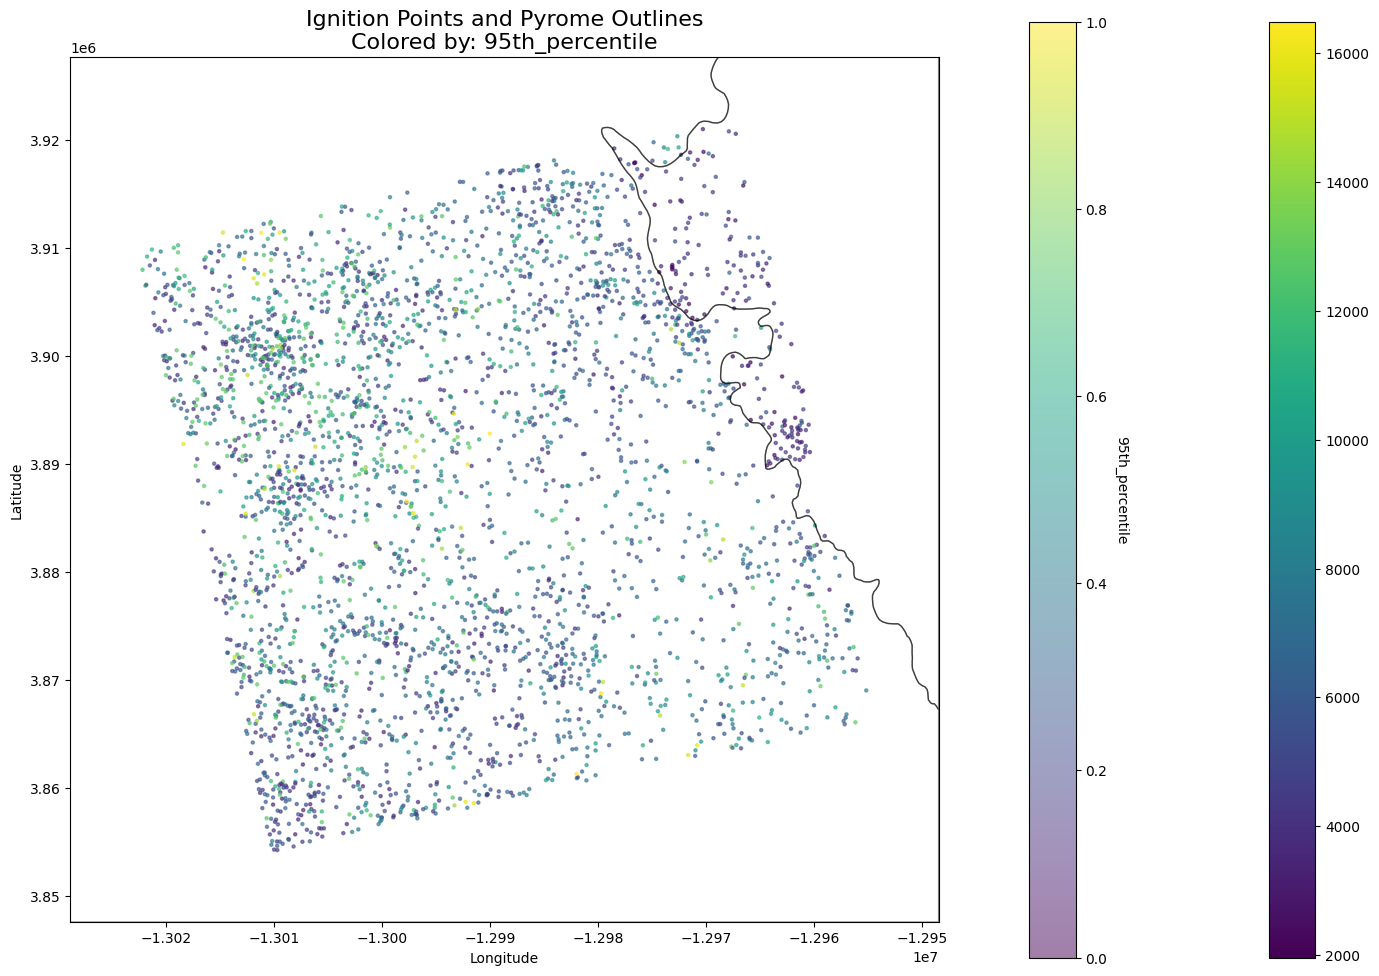

Plot saved to ignitions_map_95th_percentile.png
Failed to add basemap: 'NoneType' object has no attribute 'shape'
Continuing without basemap...


<Figure size 640x480 with 0 Axes>

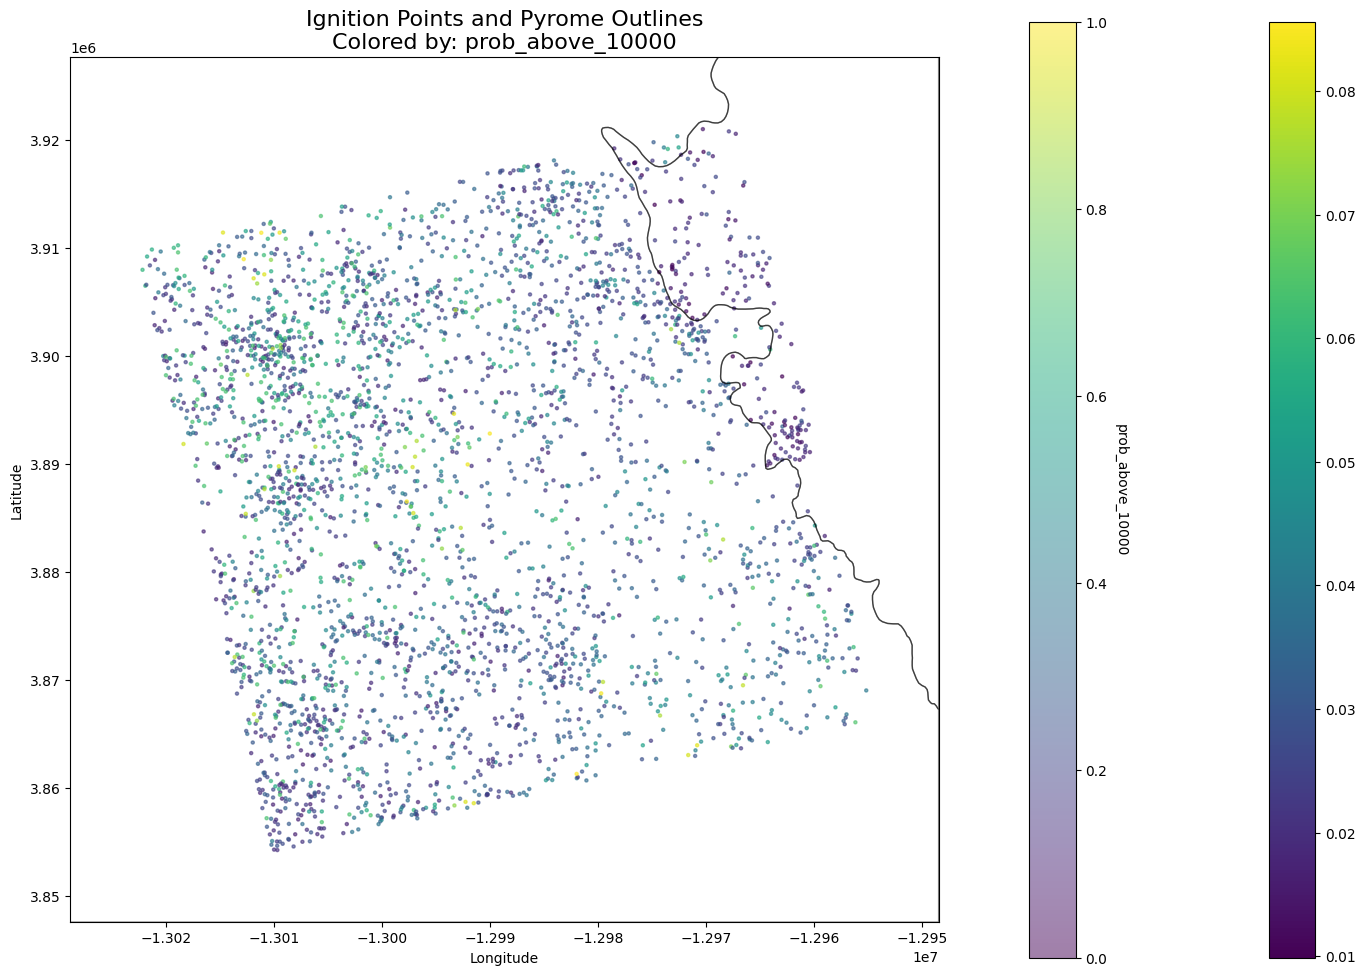

Plot saved to ignitions_map_prob_above_10000.png


<Figure size 640x480 with 0 Axes>

In [62]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from shapely.geometry import Point, box
import numpy as np

def plot_ignitions_with_pyromes(df, pyrome_shapefile_path, column_name, output_path=None, buffer_percentage=0.1):
    """
    Plot ignition points on a map with pyrome outlines in the background.

    Args:
    df (pandas.DataFrame): DataFrame containing 'Latitude' and 'Longitude' columns
    pyrome_shapefile_path (str): Path to the pyrome shapefile
    column_name (str): Name of the column to use for coloring the points
    output_path (str, optional): Path to save the output image. If None, the plot is displayed instead.
    buffer_percentage (float): Percentage of the data range to use as a buffer around the bounding box
    """
    # Load pyrome shapefile
    pyromes = gpd.read_file(pyrome_shapefile_path)
    pyromes = pyromes.to_crs(epsg=3857)  # Web Mercator projection

    # Create GeoDataFrame from the input DataFrame
    geometry = [Point(xy) for xy in zip(df['Longitude'], df['Latitude'])]
    gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")
    gdf = gdf.to_crs(epsg=3857)  # Web Mercator projection

    # Calculate bounding box with buffer
    minx, miny, maxx, maxy = gdf.total_bounds
    x_buffer = (maxx - minx) * buffer_percentage
    y_buffer = (maxy - miny) * buffer_percentage
    bbox = box(minx - x_buffer, miny - y_buffer, maxx + x_buffer, maxy + y_buffer)

    # Clip pyromes to bounding box
    pyromes = pyromes.clip(bbox)

    # Create the plot
    fig, ax = plt.subplots(figsize=(15, 10))

    # Plot pyrome outlines
    pyromes.boundary.plot(ax=ax, linewidth=1, color='black', alpha=0.5)

    # Plot ignition points
    scatter = gdf.plot(ax=ax, column=column_name, cmap='viridis', markersize=5, alpha=0.6, legend=True)

    # Customize colorbar
    cbar = plt.colorbar(scatter.collections[0], ax=ax, pad=0.08)
    cbar.set_label(column_name, rotation=270, labelpad=15)

    # Try to add basemap, if it fails, continue without it
    try:
        ctx.add_basemap(ax, source=ctx.providers.Stamen.TerrainBackground)
    except Exception as e:
        print(f"Failed to add basemap: {e}")
        print("Continuing without basemap...")

    # Set plot title and labels
    plt.title(f"Ignition Points and Pyrome Outlines\nColored by: {column_name}", fontsize=16)
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")

    # Keep axis values as we might not have a basemap
    ax.set_axis_on()

    # Set extent to bounding box
    ax.set_xlim(bbox.bounds[0], bbox.bounds[2])
    ax.set_ylim(bbox.bounds[1], bbox.bounds[3])

    # Adjust layout
    plt.tight_layout()
    plt.show()

    # Save or display the plot
    if output_path:
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        print(f"Plot saved to {output_path}")
    else:
        plt.show()

# Usage example
import pandas as pd

# Load your DataFrame

# Path to your pyrome shapefile
pyrome_shapefile_path = 'data/pyrome_shp/Pyromes_CONUS_20200206.shp'

# Plot and save
plot_ignitions_with_pyromes(final_df, pyrome_shapefile_path, '95th_percentile', 'ignitions_map_95th_percentile.png')
plot_ignitions_with_pyromes(final_df, pyrome_shapefile_path, 'prob_above_10000', 'ignitions_map_prob_above_10000.png')

Failed to add basemap: 'NoneType' object has no attribute 'shape'
Continuing without basemap...
Failed to add basemap: 'NoneType' object has no attribute 'shape'
Continuing without basemap...


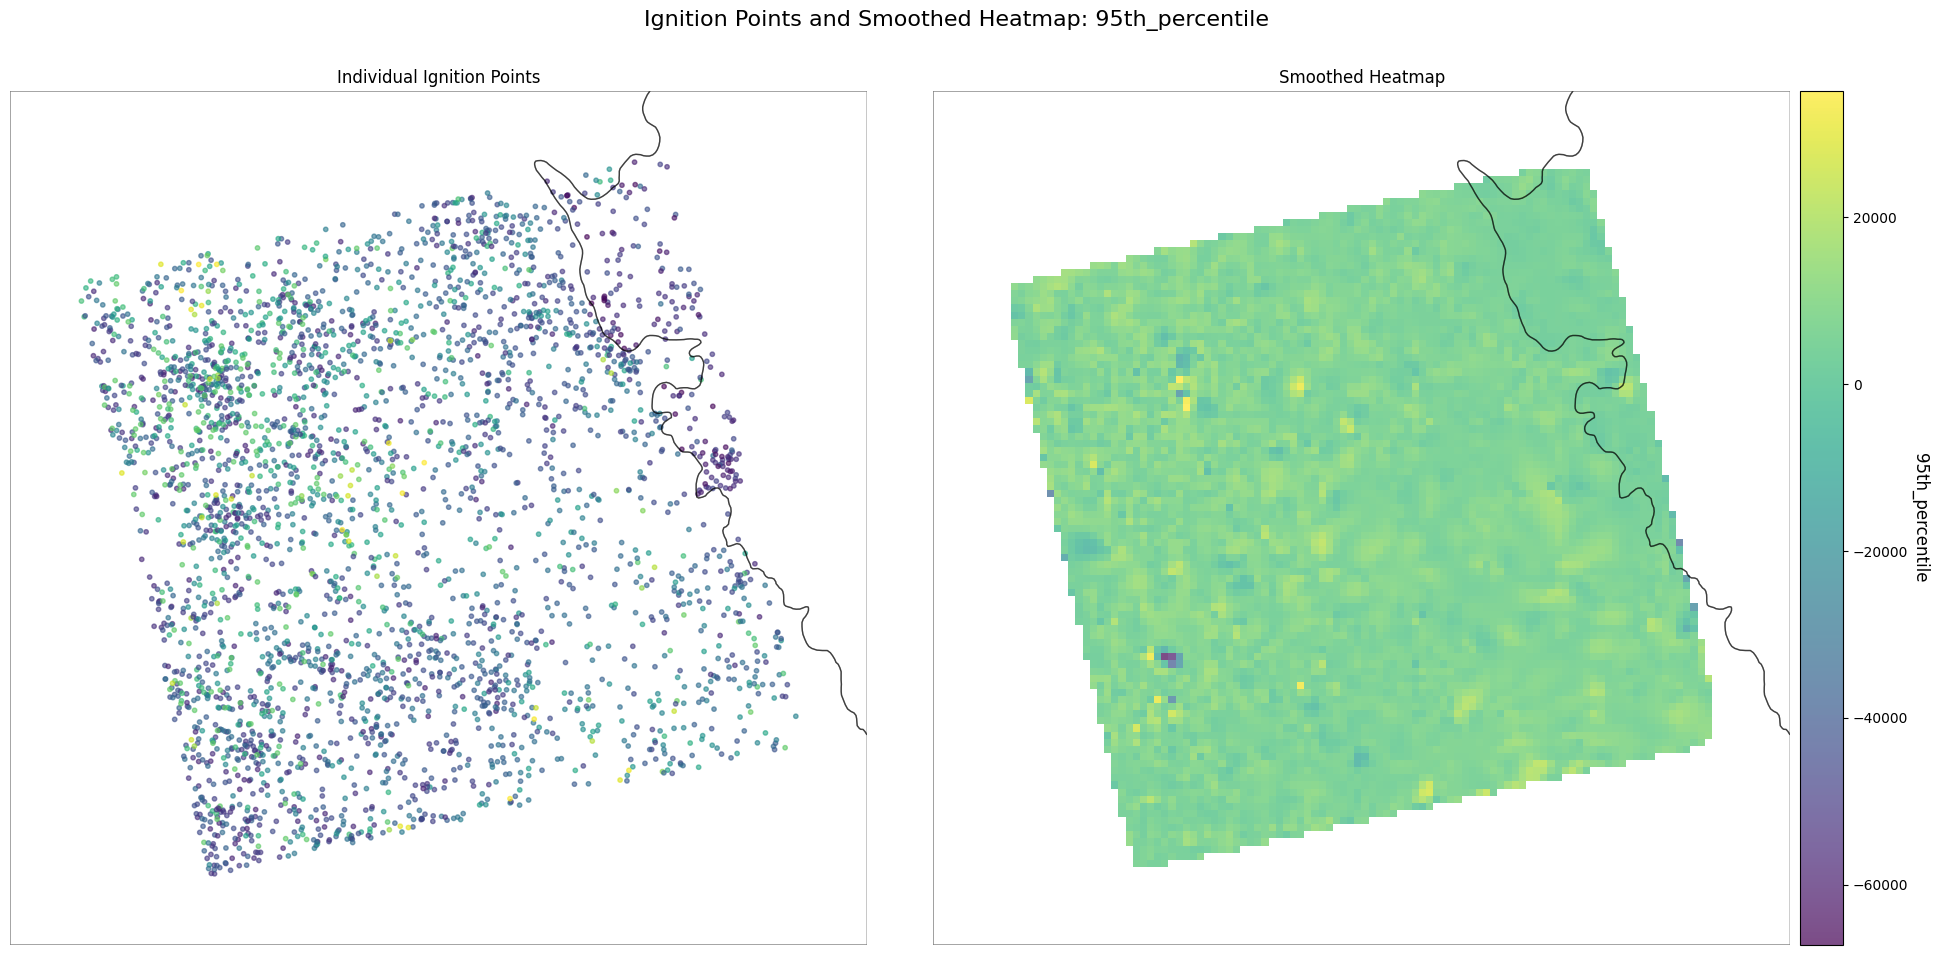

Plot saved to ignitions_map_95th_percentile.png
Failed to add basemap: 'NoneType' object has no attribute 'shape'
Continuing without basemap...
Failed to add basemap: 'NoneType' object has no attribute 'shape'
Continuing without basemap...


<Figure size 640x480 with 0 Axes>

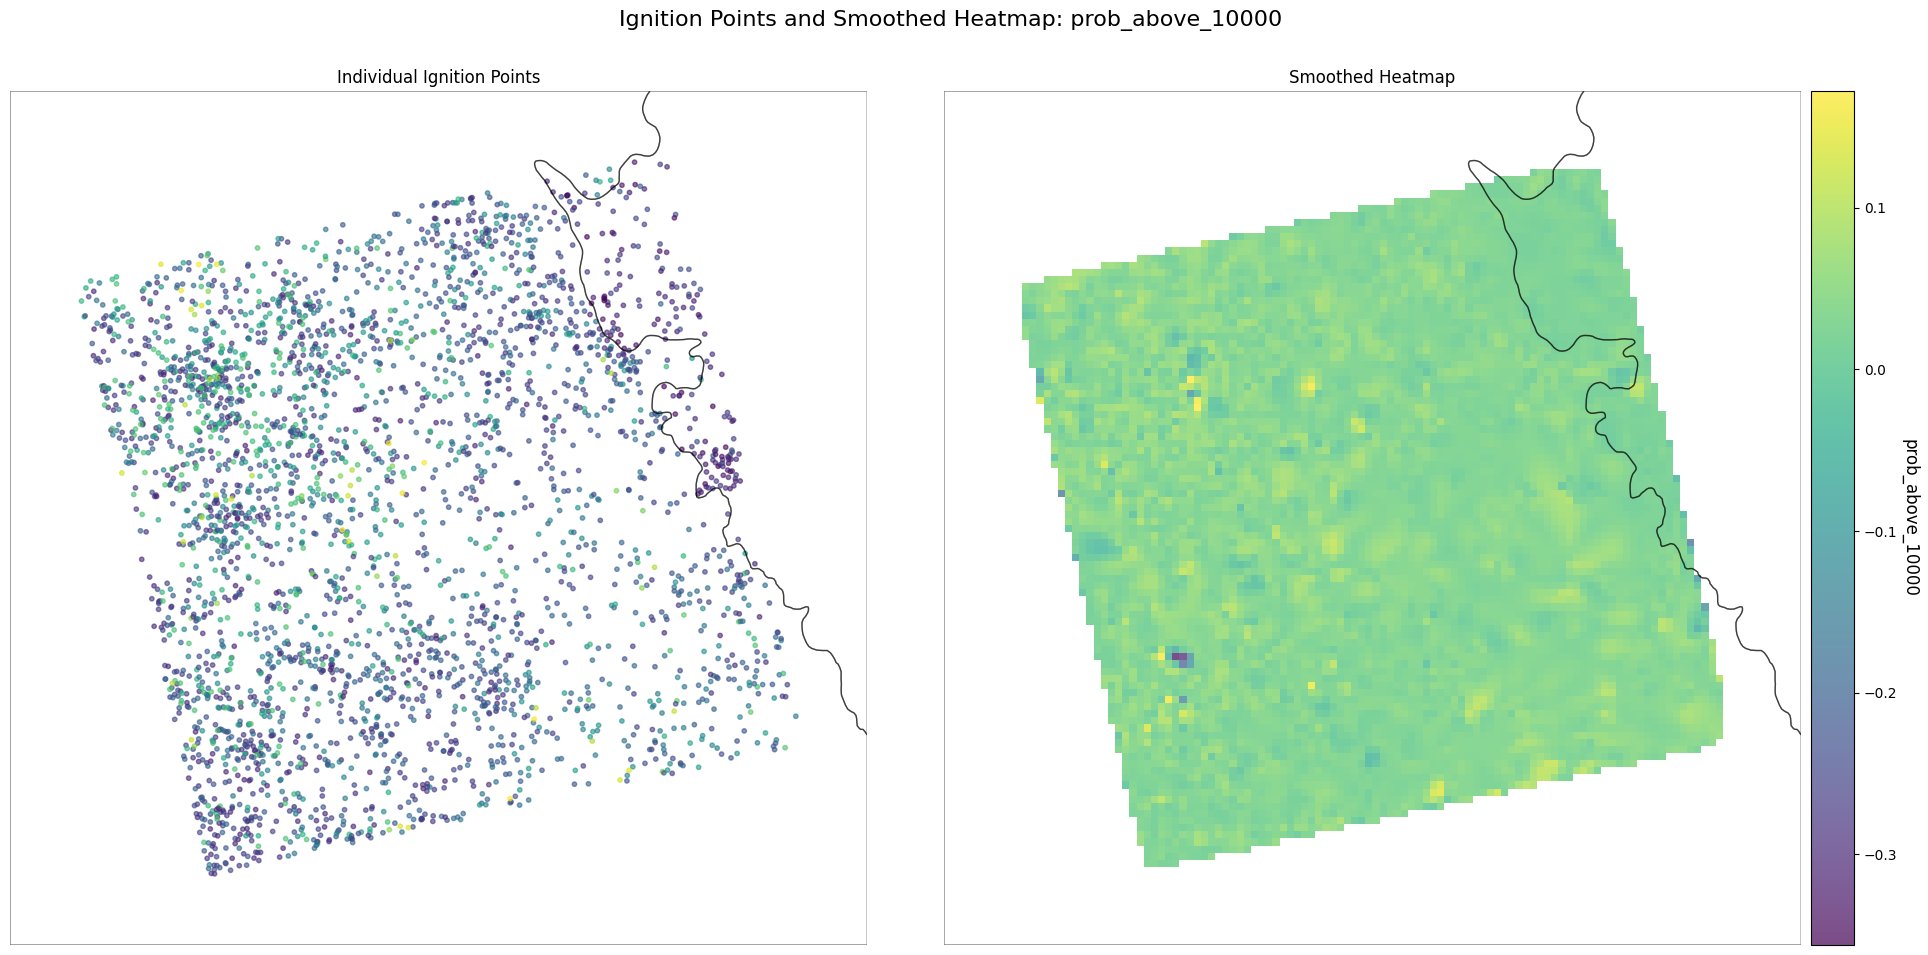

Plot saved to ignitions_map_prob_above_10000.png


<Figure size 640x480 with 0 Axes>

In [64]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from shapely.geometry import Point, box
import numpy as np
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_ignitions_with_smoothing(df, pyrome_shapefile_path, column_name, output_path=None, buffer_percentage=0.1):
    """
    Plot ignition points and a smoothed heatmap on a map with pyrome outlines in the background.

    Args:
    df (pandas.DataFrame): DataFrame containing 'Latitude', 'Longitude', and the specified column
    pyrome_shapefile_path (str): Path to the pyrome shapefile
    column_name (str): Name of the column to use for coloring the points and creating the heatmap
    output_path (str, optional): Path to save the output image. If None, the plot is displayed instead.
    buffer_percentage (float): Percentage of the data range to use as a buffer around the bounding box

    Returns:
    None
    """
    # Load pyrome shapefile
    pyromes = gpd.read_file(pyrome_shapefile_path)
    pyromes = pyromes.to_crs(epsg=3857)  # Web Mercator projection

    # Create GeoDataFrame from the input DataFrame
    geometry = [Point(xy) for xy in zip(df['Longitude'], df['Latitude'])]
    gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")
    gdf = gdf.to_crs(epsg=3857)  # Web Mercator projection

    # Calculate bounding box with buffer
    minx, miny, maxx, maxy = gdf.total_bounds
    x_buffer = (maxx - minx) * buffer_percentage
    y_buffer = (maxy - miny) * buffer_percentage
    bbox = box(minx - x_buffer, miny - y_buffer, maxx + x_buffer, maxy + y_buffer)

    # Clip pyromes to bounding box
    pyromes = pyromes.clip(bbox)

    # Create the plot with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    fig.suptitle(f"Ignition Points and Smoothed Heatmap: {column_name}", fontsize=16)

    # Plot pyrome outlines on both subplots
    pyromes.boundary.plot(ax=ax1, linewidth=1, color='black', alpha=0.5)
    pyromes.boundary.plot(ax=ax2, linewidth=1, color='black', alpha=0.5)

    # Plot individual points
    scatter = ax1.scatter(gdf.geometry.x, gdf.geometry.y, c=gdf[column_name], cmap='viridis', s=10, alpha=0.6)
    ax1.set_title("Individual Ignition Points")

    # Create smoothed heatmap
    x = gdf.geometry.x.values
    y = gdf.geometry.y.values
    z = gdf[column_name].values

    xi = np.linspace(x.min(), x.max(), 100)
    yi = np.linspace(y.min(), y.max(), 100)
    xi, yi = np.meshgrid(xi, yi)

    zi = griddata((x, y), z, (xi, yi), method='cubic')
    heatmap = ax2.imshow(zi, extent=[x.min(), x.max(), y.min(), y.max()], 
                         origin='lower', cmap='viridis', alpha=0.7)
    ax2.set_title("Smoothed Heatmap")

    # Add basemap to both subplots
    for ax in (ax1, ax2):
        try:
            ctx.add_basemap(ax, source=ctx.providers.Stamen.TerrainBackground)
        except Exception as e:
            print(f"Failed to add basemap: {e}")
            print("Continuing without basemap...")

        ax.set_xlim(bbox.bounds[0], bbox.bounds[2])
        ax.set_ylim(bbox.bounds[1], bbox.bounds[3])
        ax.set_axis_off()

    # Add colorbar
    divider = make_axes_locatable(ax2)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = plt.colorbar(heatmap, cax=cax)
    cbar.set_label(column_name, rotation=270, labelpad=15, fontsize=12)

    # Adjust layout
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    # Save or display the plot
    if output_path:
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        print(f"Plot saved to {output_path}")
    else:
        plt.show()

# Usage example
import pandas as pd

# Load your DataFrame
#df = pd.read_csv('data/sheets/010_024.csv')  # Adjust the path as needed

# Path to your pyrome shapefile
pyrome_shapefile_path = 'data/pyrome_shp/Pyromes_CONUS_20200206.shp'

# Plot and save
plot_ignitions_with_smoothing(final_df, pyrome_shapefile_path, '95th_percentile', 'ignitions_map_95th_percentile.png')
plot_ignitions_with_smoothing(final_df, pyrome_shapefile_path, 'prob_above_10000', 'ignitions_map_prob_above_10000.png')